In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [9]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe660692880>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe6713e5d00>,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01'}

In [12]:
# Get a list of column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()[0]
print(f'The most recent date in the dataset is: {recent_date}')

The most recent date in the dataset is: 2017-08-23


In [14]:
def date_to_str(date):
    year, month, day = str(date).split('-')
    return year, month, day
year, month, day = date_to_str(recent_date)

<Figure size 720x576 with 0 Axes>

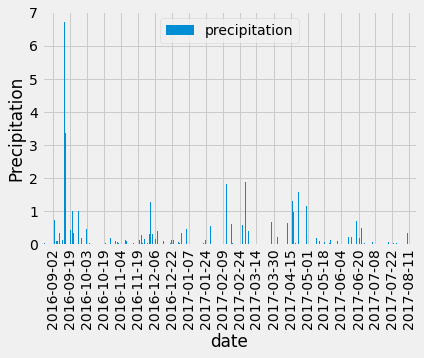

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = (dt.date(int(year), int(month), int(day)) - \
    dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter( Measurement.date>=query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,
                  columns=['date', 'precipitation'])
df =df.dropna(how='any')

# Sort the dataframe by date
df = df.sort_values(['date'], ascending=True)
df = df.set_index('date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,8))
ax = df.plot.bar()
# # Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_half_year)
ax.set_ylabel('Precipitation')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
number_of_station = session.query(func.count(distinct(Measurement.station)))[0][0]
print(f'The total number stations in the dataset is: {number_of_station}')

The total number stations in the dataset is: 9


In [44]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(Measurement.tobs),
                    func.max(Measurement.tobs), 
                    func.avg(Measurement.tobs)).\
    filter(Measurement.station==active_station[0][0]).all()
temp

[(54.0, 85.0, 71.66378066378067)]

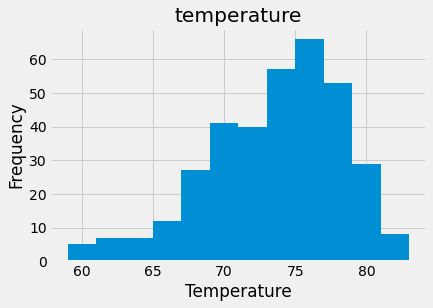

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.tobs).\
    filter( Measurement.date>=query_date).\
    filter(Measurement.station==active_station[0][0]).all()
temperature_df = pd.DataFrame(temperature, columns=['temperature'])
ax_temp = most_active_station_df.hist(bins=12, legend=False)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [21]:
# Close Session
session.close()